# Milestone 2
## 2.1 Imports and data loading

In [1]:
import findspark
findspark.init()
from pyspark.sql import *
spark = SparkSession.builder.getOrCreate()

import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import to_date, dayofmonth, dayofweek, month, year, length, udf, greatest
import pyspark.sql.functions as f

import seaborn as sns

import pandas as pd

In [5]:
DATA_PATH = 'data/'
FILE_NAME_00 = 'amazon_reviews_us_Books_v1_00.tsv.gz'
FILE_NAME_01 = 'amazon_reviews_us_Books_v1_01.tsv.gz'
FILE_NAME_02 = 'amazon_reviews_us_Books_v1_02.tsv.gz'


In [33]:
data_00 = spark.read.option("sep", "\t").option("header", "true").csv(DATA_PATH + FILE_NAME_00)
data_01 = spark.read.option("sep", "\t").option("header", "true").csv(DATA_PATH + FILE_NAME_01)
data_02 = spark.read.option("sep", "\t").option("header", "true").csv(DATA_PATH + FILE_NAME_02)

data = data_00.union(data_01).union(data_02)

In [36]:
data.show(2)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   25933450| RJOVP071AVAJO|0439873800|      84656342|There Was an Old ...|           Books|          5|            0|          0|   N|                Y|          Five Stars|I love it and so ...| 2015-08-31|
|         US|    1801372|R1ORGBETCDW3AI|1623953553|     729938122|      I Saw a Friend|           Books|          5|    

Our data looks like this



|marketplace|customer_id|    review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|review_headline|         review_body|review_date|
|-----------|-----------|-------------|----------|--------------|--------------------|----------------|-----------|-------------|-----------|----|-----------------|---------------|--------------------|-----------|
|         US|   25933450|RJOVP071AVAJO|0439873800|      84656342|There Was an Old ...|           Books|          5|            0|          0|   N|                Y|     Five Stars|I love it and so ...| 2015-08-31|


## 2.2 Analysis of some features

Before doing some real data analysis, we should look at some of the features and decide and they are worth keeping.

The `marketplace column` won't be usefull since all the reviews are only for the US market.

**TODO** Talk about other columns



---
`verified_purchase` column : This might have an influence, since non-verified purchases won't be as reliable since poeple might not have actually bought the product. We will group all our data by `verified_purchase`, and compute look at the average rating.

In [41]:
verified_status = data.groupby('verified_purchase').agg(f.avg('star_rating'), f.count('review_id'), f.stddev('star_rating')) 
_ = verified_status.persist()

We will convert it to a Pandas dataframe, an drop the NA row.

In [45]:
ver_pandas = verified_status.toPandas()
ver_pandas.dropna(inplace=True)

Since we have the mean and the standard deviation, we can compute the err_mean by using **NAME OF FORMULA**

In [47]:
ver_pandas['err_mean']=1.96*ver_pandas['stddev_samp(star_rating)']/np.sqrt(ver_pandas['count(review_id)'])
ver_pandas.reset_index(inplace=True,drop=True)
ver_pandas

,verified_purchase,avg(star_rating),count(review_id),stddev_samp(star_rating),err_mean
0,Y,4.452843,9920149,1.021810,0.000636
1,N,4.226896,9611045,1.209875,0.000765


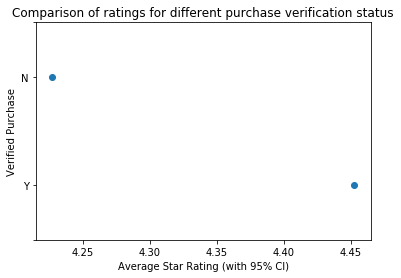

In [48]:
y = [1, 3]

plt.figure()
plt.errorbar(ver_pandas['avg(star_rating)'], y, xerr=ver_pandas['err_mean'], fmt = 'o')
plt.yticks((0, 1, 3, 4), ('', ver_pandas['verified_purchase'][0], ver_pandas['verified_purchase'][1],'')) 
plt.ylabel('Verified Purchase')
plt.xlabel('Average Star Rating (with 95% CI)')
plt.title('Comparison of ratings for different purchase verification status')
plt.show()

We can clearly see, with a 95% confidence interval, that the average rating is higher for verified reviews. **TODO WHY**. From now on, we will only keep verified reviews for our analysis.

## 2.3 Rating vs vote counts & helpful votes

### Some helper functions

In [53]:
def keep_verified(data):
    return data.filter(data.verified_purchase == 'Y')

In [2]:
def group_by_product(data):
    avg_stars = data.groupby('product_id', 'product_title').agg(f.avg('star_rating'), f.count('review_id'), f.sum('helpful_votes'),f.sum('total_votes'),f.min(to_date(data['review_date'], 'yyyy-MM-dd')), f.stddev('star_rating'))
    avg_stars.persist()
    avg_stars = avg_stars.withColumnRenamed('count(review_id)', 'n_reviews') \
                        .withColumnRenamed('sum(total_votes)', 'total_votes') \
                        .withColumnRenamed('sum(helpful_votes)', 'helpful_votes') \
                        .withColumnRenamed('avg(star_rating)', 'rating') \
                        .withColumnRenamed("min(to_date(`review_date`, 'yyyy-MM-dd'))", 'first_date') \
                        .withColumnRenamed('stddev_samp(star_rating)', 'std_rating')
    

    return avg_stars

In [54]:
data = keep_verified(data)

In [9]:
avg_stars = group_by_product(data)

In [10]:
avg_stars.count()

3417300

In [139]:
main_avg_stars = avg_stars.where('n_reviews > 10')

In [140]:
main_avg_stars.show()

+----------+--------------------+---------+-----------+------------------+-------------+
|product_id|       product_title|n_reviews|total_votes|            rating|helpful_votes|
+----------+--------------------+---------+-----------+------------------+-------------+
|014241543X|           If I Stay|     1003|     1842.0| 4.154536390827517|       1441.0|
|1250056608|Rough Justice: Si...|       12|        7.0|              4.25|          7.0|
|0340909129|Do It Tomorrow an...|       30|      519.0|               4.6|        439.0|
|1937013200|Savage Worlds Del...|       86|      125.0| 4.848837209302325|        110.0|
|0736432841|Anna & Elsa #1: A...|       42|       70.0| 4.619047619047619|         59.0|
|1940484138|Common Core Asses...|       13|       22.0|3.6923076923076925|         17.0|
|0307476073|Wild: From Lost t...|     1350|     2734.0| 4.099259259259259|       2203.0|
|1416299025|Outlander 2016 Bo...|       11|       54.0|4.7272727272727275|         50.0|
|0060192674|Everythin

In [141]:
main_avg_stars.count()

358136

In [17]:
by_product = main_avg_stars.toPandas()

In [18]:
by_product['ratio_helpful'] = by_product['helpful_votes'] / by_product['total_votes']

In [ ]:
by_product.sort_values(by='n_reviews')

In [34]:
grouped_product_ratio = by_product.groupby([pd.cut(by_product['ratio_helpful'], bins=50, include_lowest=True)]).mean()

In [35]:
grouped_product_ratio.head()

,n_reviews,total_votes,rating,helpful_votes,ratio_helpful
ratio_helpful,,,,,
"(-0.002, 0.02]",16.917382,3.242523,4.524375,0.000592,0.000004
"(0.02, 0.04]",32.625000,39.625000,4.524151,1.333333,0.034391
"(0.04, 0.06]",26.079646,31.141593,4.505108,1.592920,0.051706
"(0.06, 0.08]",23.104478,30.711443,4.430526,2.179104,0.071093
"(0.08, 0.1]",22.717143,29.394286,4.389249,2.682857,0.092393


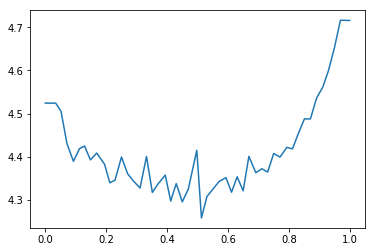

In [31]:
plt.plot(grouped_product_ratio['ratio_helpful'], grouped_product_ratio['rating'])

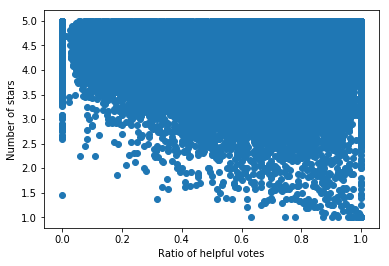

In [23]:
plt.scatter(by_product['ratio_helpful'], by_product['rating'])
plt.xlabel('Ratio of helpful votes')
plt.ylabel('Number of stars')
plt.show()

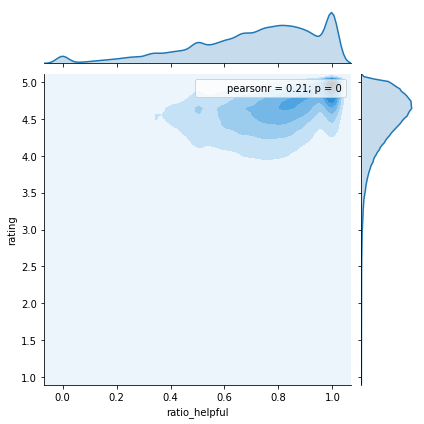

In [45]:
sns.jointplot(x = by_product['ratio_helpful'], y = by_product['rating'], kind='kde')

**Observation**<br>
We can see that the lower the number of helpful votes is, the higher the rating. However, unfortunately we cannot come up with an possible explanation for the ratio of helpful votes to influence the rating, so we cannot reason if the relationship is causal.

In [60]:
grouped_product_n_reviews = by_product.groupby([pd.cut(by_product['n_reviews'], bins=np.logspace(1, 3), include_lowest=True)]).mean()
grouped_product_n_reviews

,n_reviews,total_votes,rating,helpful_votes,ratio_helpful
n_reviews,,,,,
"(9.999, 10.985]",NaN,NaN,NaN,NaN,NaN
"(10.985, 12.068]",11.457496,22.154028,4.468589,15.778729,0.718889
"(12.068, 13.257]",13.000000,26.126264,4.472138,18.482839,0.716416
"(13.257, 14.563]",14.000000,28.158834,4.476638,19.881041,0.713630
"(14.563, 15.999]",15.000000,30.292548,4.468246,21.485771,0.713505
"(15.999, 17.575]",16.465675,34.735785,4.474098,24.608667,0.714995
"(17.575, 19.307]",18.475165,39.404625,4.480337,27.736455,0.710574
"(19.307, 21.21]",20.481149,45.999582,4.461702,32.123864,0.705816
"(21.21, 23.3]",22.479802,49.640542,4.468865,35.285075,0.711743


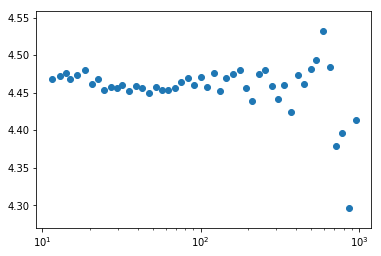

In [61]:
plt.scatter(grouped_product_n_reviews['n_reviews'], grouped_product_n_reviews['rating'])
plt.xscale('log')

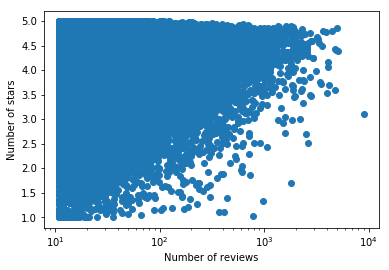

In [16]:
plt.scatter(by_product['n_reviews'], by_product['rating'])
plt.xscale('log')
plt.xlabel('Number of reviews')
plt.ylabel('Number of stars')
plt.show()

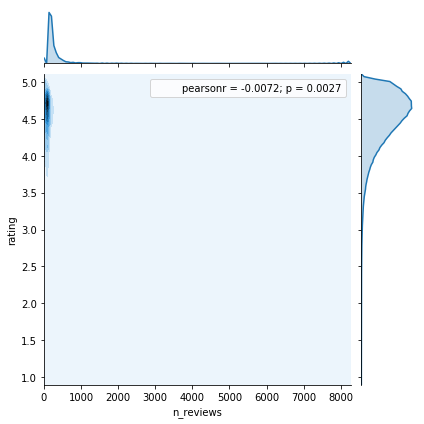

In [46]:
sns.jointplot(x = by_product['n_reviews'], y = by_product['rating'], kind='kde')

**Observation**<br>
We can see that the higher the number of reviews is, the higher the rating. However, the causal relationship is most likely causal in the sense that better products have higher ratings, but better products also have more people that buy them, so more reviews.

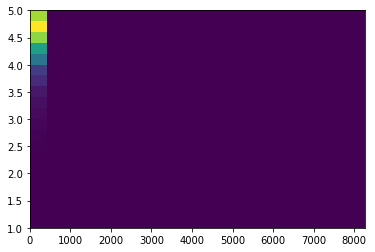

In [101]:
plt.hist2d(by_product['n_reviews'], by_product['rating'], bins=20)
#plt.xlim(0, 100)
plt.show()

## 2.4 Analysis of Time Based Features

In [70]:

def get_time_analysis(data, time_name):
    time_types = {'month' : month('date'), 'year' : year('date'), 'dayofweek' : dayofweek('date'), 'dayofmonth' : dayofmonth('date')}
    group_function = time_types[time_name]
    data_bytime = data.groupby(group_function).agg(f.avg('star_rating'), f.count('review_id'), f.stddev('star_rating')).withColumnRenamed('avg(star_rating)', 'rating').withColumnRenamed('stddev_samp(star_ratinng)', 'std_rating').withColumnRenamed(time_name + '(date)', time_name)
    data_bytime_sorted = data_bytime.sort(time_name)
    
    
    by_time_pd = data_bytime_sorted.toPandas()
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
    ax1.plot(by_time_pd[time_name], by_time_pd['rating'])
    ax1.fill_between(by_time_pd[time_name], by_time_pd['rating'] - 1.96 * by_time_pd['stddev_samp(star_rating)'] / np.sqrt(by_time_pd['count(review_id)']), \
                                           by_time_pd['rating'] + 1.96 * by_time_pd['stddev_samp(star_rating)'] / np.sqrt(by_time_pd['count(review_id)']), alpha=0.5)
    ax1.set_xlabel(time_name)
    ax1.set_ylabel('Average Rating')
    ax1.set_title('Avergage Rating vs ' + time_name)
    
    ax2.plot(by_time_pd[time_name], by_time_pd['count(review_id)'])
    
    ax2.set_xlabel(time_name)
    ax2.set_ylabel('Number of reviews')
    ax2.set_title('Number of ratings vs ' + time_name)
    plt.show()
    

In [72]:
by_time = data.select(data['star_rating'],to_date(data['review_date'], 'yyyy-MM-dd').alias('date'), data['review_id'])

In [74]:
get_time_analysis(by_time, 'month')

KeyboardInterrupt: 

In [ ]:
get_time_analysis(by_time, 'year')

In [ ]:
get_time_analysis(by_time, 'dayofweek')

In [ ]:
get_time_analysis(by_time, 'dayofmonth')

## 2.5 Text analysis

In [146]:
div_by_10 = udf(lambda x : 0 if x is None else 1*int(x / 10))
div_by_100 = udf(lambda x : 0 if x is None else 10*int(x / 100))
by_review_length = data.select(data['star_rating'], \
                               div_by_10(length(data['review_headline'])).alias('title_length'), \
                               div_by_100(length(data['review_body'])).alias('body_length'), \
                                      data['review_id'])
by_review_length.persist()

DataFrame[star_rating: string, title_length: string, body_length: string, review_id: string]

In [147]:
by_review_length.show()

+-----------+------------+-----------+--------------+
|star_rating|title_length|body_length|     review_id|
+-----------+------------+-----------+--------------+
|          5|           1|          0| RJOVP071AVAJO|
|          5|           6|         30|R1ORGBETCDW3AI|
|          5|           1|          0| R7TNRFQAOUTX5|
|          5|           1|          0|R2GANXKDIFZ6OI|
|          5|           1|          0|R2NYB6C3R8LVN6|
|          2|           3|        150|R13U5PBJI1H94K|
|          5|           5|         70|R1H8UVH990F8VE|
|          5|           1|          0|R2MC0N30WZMRQ5|
|          5|           1|          0| R2NO2HXK16Y4J|
|          5|           1|          0|R245YIAVJK82ZL|
|          5|           1|          0| RFBMLBWQOZ1UM|
|          5|           3|         10| RHE1FEWV3KTQH|
|          5|           1|          0|R2BB9U7PHO7ETO|
|          4|           1|          0|R28XJJP754GYXO|
|          3|           7|         20|R2G519UREHRO8M|
|          5|           1|  

In [148]:

by_title_length = by_review_length.where('title_length < 300').groupby('title_length').agg({'star_rating':'avg', 'review_id':'count'}).\
                    withColumnRenamed('avg(star_rating)', 'rating').withColumnRenamed('count(review_id)', 'count')
by_title_length.persist()

DataFrame[title_length: string, count: bigint, rating: double]

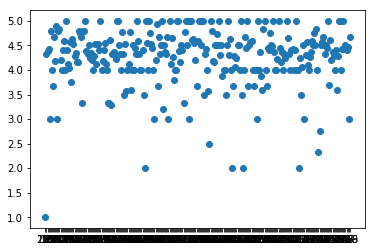

In [149]:
by_title_length_pd = by_title_length.toPandas()
by_title_length_pd
plt.scatter(by_title_length_pd['title_length'], by_title_length_pd['rating'])

In [35]:
by_body_length = by_review_length.groupby('body_length').agg({'star_rating':'avg', 'review_id':'count'}) \
                    .withColumnRenamed('avg(star_rating)', 'rating').withColumnRenamed('count(review_id)', 'count')
by_body_length.persist()

DataFrame[body_length: string, count: bigint, rating: double]

In [ ]:
by_body_length.count()

In [ ]:
by_body_length_pd = by_body_length.toPandas()
by_body_length_pd
plt.plot(by_body_length_pd['body_length'], by_body_length_pd['count'])

## 2.6 Comparaison betwen countries

In this part, we want to see if there are any differences between the way people rate articles in differents countries. 

To be able to correcly compare ratings between countries, we will have to limit our dataset to products that are available in both regions. Moreover, we will only keep reviews given during the same time period, since we saw earlier that the year of the review had quite a big impact on the rating. 

> e.g. If for a given article we have reviews from 2001 to 2015 in the US, but only from 2005 to 2015 in the UK, we will discard all reviews in the us before 2005.

We will first do pairwise comparaisons, since it is the way we will have the most common data. We might also do a comparaison between all 5 available countries, but the remaining number of reviews might be limited.

For milestone 2, we will only study the difference between the US and UK, but the process will be the same for other pairs of countries.

---

First, we will open the datasets, as done earlier in this notebook

In [6]:
FILE_NAME_US = 'amazon_reviews_multilingual_US_v1_00.tsv.gz'
FILE_NAME_UK = 'amazon_reviews_multilingual_UK_v1_00.tsv.gz'

In [55]:
data_us = spark.read.option("sep", "\t").option("header", "true").csv(DATA_PATH + FILE_NAME_US)
data_uk = spark.read.option("sep", "\t").option("header", "true").csv(DATA_PATH + FILE_NAME_UK)
data_us = keep_verified(data_us)
data_uk = keep_verified(data_uk)

WIll we use again the group_by_product function from earlier, which will limit the data to one entry per product, and also give us the date of the first review for a given product

In [56]:
avg_us = group_by_product(data_us)
avg_uk = group_by_product(data_uk)

_ = avg_us.persist()
_ = avg_uk.persist()

# To be able to differenciate columns after a later join
us = avg_us.alias("us")
uk = avg_uk.alias("uk")

We can join the products from US and UK, with an inner join, so we only have common products

In [59]:
us_uk = us.join(uk, f.col('us.product_id') == f.col('uk.product_id'))

We can this here some of the entries of the us_uk table, were the left-hand side columns correspond to the US data, and the right-hand side columns to the UK data

|product_id|       product_title|           rating|n_reviews|helpful_votes|total_votes|first_date|        std_rating|product_id|       product_title|rating|n_reviews|helpful_votes|total_votes|first_date|       std_rating|
|----------|--------------------|-----------------|---------|-------------|-----------|----------|------------------|----------|--------------------|------|---------|-------------|-----------|----------|------------------|
|0099428385|I Don't Know How ...|4.666666666666667|        3|          2.0|        3.0|2011-05-02|0.5773502691896258|0099428385|I Don't Know How ...|4.454545454545454|       11|         12.0|       19.0|2009-09-04|0.8201995322647243|
|0141038225|Antifragile: Thin...|4.666666666666667|        3|          2.0|        3.0|2013-09-30|0.5773502691896258|0141038225|Antifragile: Thin...|              3.5|       14|         16.0|       26.0|2013-11-28|1.5566235649883122|
|0241951461|Penguin Essential...|              4.0|        3|          1.0|        5.0|2014-09-06|               1.0|0241951461|My Family and Oth...|4.333333333333333|        3|          1.0|       14.0|2012-12-03|1.1547005383792517|


We will use this table to get for each product the earliest date reviews were available in both countries 

In [62]:
latest_date = us_uk.select(f.col('us.product_id'),greatest(f.col('us.first_date'), f.col('uk.first_date'))) \
                        .withColumnRenamed("product_id", "id").withColumnRenamed("greatest(us.first_date, uk.first_date)", 'latest_date')

Again, here is an excerpt of the `latest_date` table, where `latest_date` is the date starting when the product `id` had received reviews in both countries

|        id|latest_date|
|----------|-----------|
|B00000IQW3| 2007-07-26|
|B00000IMCW| 2015-01-08|


We can now, for the US, and the UK, only keep reviews that were writen when the article was available in both countries

In [63]:
us_common_with_date = data_us.join(latest_date, data_us['product_id'] == latest_date['id'])
us_common_reviews = us_common_with_date.where('review_date >= latest_date')
_ = us_common_reviews.persist()

uk_common_with_date = data_uk.join(latest_date, data_uk['product_id'] == latest_date['id'])
uk_common_reviews = uk_common_with_date.where('review_date >= latest_date')
_ = uk_common_reviews.persist()

And now that we have reduced our dataset to only reviews of articles that are common between the uk and us, and for the same time period, we can get some statistics for each product

In [67]:
common_us_avg = group_by_product(us_common_reviews)
common_uk_avg = group_by_product(uk_common_reviews)

Here is an excerpt of the `common_us_avg` table

|product_id|       product_title|           rating|n_reviews|helpful_votes|total_votes|first_date|        std_rating|
|----------|--------------------|-----------------|---------|-------------|-----------|----------|------------------|
|0099428385|I Don't Know How ...| 4.666666666666667|        3|          2.0|        3.0|2011-05-02| 0.5773502691896258|
|0141038225|Antifragile: Thin...|               4.5|        2|          1.0|        1.0|2014-01-15| 0.7071067811865476|
|0241951461|Penguin Essential...|               4.0|        3|          1.0|        5.0|2014-09-06|                1.0|
|0385394233|Lean In: Women, W...| 4.454545454545454|       22|          4.0|       10.0|2014-01-03| 0.8578640544577771|

Here is an excerpt of the `common_uk_avg` table

|product_id|       product_title|           rating|n_reviews|helpful_votes|total_votes|first_date|        std_rating|
|----------|--------------------|-----------------|---------|-------------|-----------|----------|------------------|
|0099428385|I Don't Know How ...| 4.444444444444445|        9|          3.0|        6.0|2011-12-19|  0.881917103688197|
|0141038225|Antifragile: Thin...|               3.5|       14|         16.0|       26.0|2013-11-28| 1.5566235649883122|
|0385394233|Lean in: Women, W...|               5.0|        1|          0.0|        0.0|2013-12-24|                NaN|
|0553505416|Die Trying: (Jack...| 4.705882352941177|       17|          7.0|       10.0|2011-12-23| 0.9851843661437779|

Now that our data has been cleaned, we can try and see if there is a difference between the ratings from the US and the UK. 

In [68]:
us_pd = common_us_avg.toPandas()
uk_pd = common_uk_avg.toPandas()

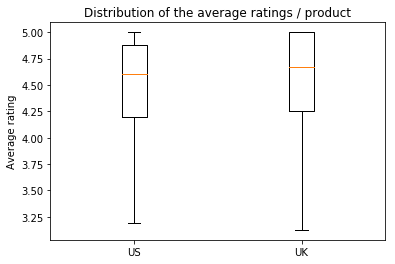

In [69]:
plt.boxplot([us_pd['rating'], uk_pd['rating']], 0, sym='',autorange=True, labels=['US', 'UK'])
plt.title('Distribution of the average ratings / product')
plt.ylabel('Average rating')
plt.show()

We see that the median average rating is lower in the US than in the UK, but `TO COMPLETE`

## 2.7 Herding behavior

Do we have enough data to perform this analysis ?

For common articles in every countries, get the first review and compare it to the average review. Correct the bias due to the difference between countries.